Examining the Ames Housing Data

In [1]:
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
import matplotlib

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%config InlineBackend.figure_format = 'retina'  #set png here when working on notebook
%matplotlib inline

In [3]:
random.seed(31415)

#remove duplicate rows from expanded data 300 rows
mdata = pd.DataFrame.from_csv('./train.csv',index_col="Id").drop_duplicates()

#shuffle
#mdata=mdata.sample(frac=1,random_state=31415)
total_count=len(mdata.values)

In [4]:
mdata.head(1) #see what the data looks like

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


Look for interesting trends in the numeric data.

In [5]:
mdata.describe() # stats for the numeric columns

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Some columns are missing values. We should replace these with the median values. 

In [6]:
(mdata[['YrSold','SalePrice']]).groupby('YrSold').agg('count') #information by year

,SalePrice
YrSold,
2006,314
2007,329
2008,304
2009,338
2010,175


The data is in a fairely tight timeframe so would not expect to see much affacte of inflation in price.
Let's look at the dollar per square foot trend of over time to validate.

Examine the distribution of sales price and log of sales price

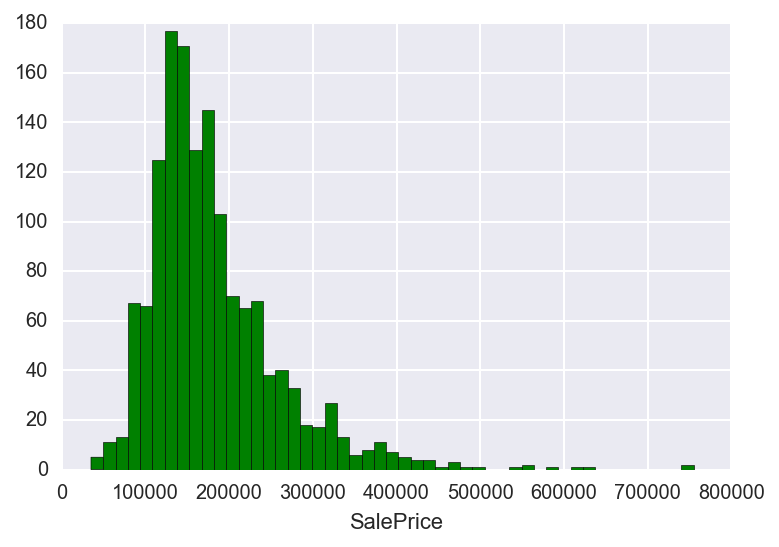

In [7]:
sns.distplot(mdata['SalePrice'], kde = False, color = 'g', hist_kws={'alpha': 1.0})

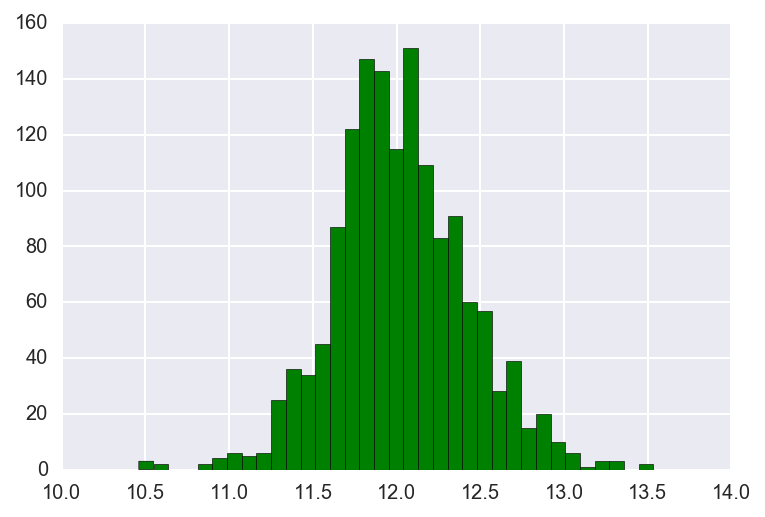

In [8]:
sns.distplot([mdata['SalePrice'].apply(lambda x: math.log(x))], kde = False, color = 'g', hist_kws={'alpha': 1.0})

The log of the sales price gives us a better distribution for training.

In [9]:
#transform the target:
mdata["SalePrice"] = np.log1p(mdata["SalePrice"])

For some of the category we can map the values to a scale. Instead of encoding these categories, features like quality ratings can easily be converted to an flat scale that will help our linear regression model.

Of these controllable factors like quality and condition will be of utmost importance to flippers

In [10]:
mdata["CentralAir"] = ((mdata["CentralAir"] == "Y") * 1.0)

In [11]:
#these are the most important features to renovators because it is the most changable feature of the dataset

quality_map = {None: 0.0, "Po": 1.0, "Fa": 2.0, "TA": 3.0, "Gd": 4.0, "Ex": 5.0}
mdata["ExterQual"] = mdata["ExterQual"].map(quality_map).astype(float)
mdata["ExterCond"] = mdata["ExterCond"].map(quality_map).astype(float)
mdata["KitchenQual"] = mdata["KitchenQual"].map(quality_map).astype(float)

#quality_map = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
mdata["BsmtQual"] = mdata["BsmtQual"].map(quality_map).astype(float)
mdata["BsmtCond"] = mdata["BsmtCond"].map(quality_map).astype(float)
mdata["HeatingQC"] = mdata["HeatingQC"].map(quality_map).astype(float)
mdata["FireplaceQu"] = mdata["FireplaceQu"].map(quality_map).astype(float)
mdata["GarageQual"] = mdata["GarageQual"].map(quality_map).astype(float)
mdata["GarageCond"] = mdata["GarageCond"].map(quality_map).astype(float)


In [12]:
finish_map={None: 0.0, "Unf": 1.0, "RFn": 2.0, "Fin": 3.0}
mdata["GarageFinish"] = mdata["GarageFinish"].map(finish_map).astype(float)


In [13]:
# Has it had a recent remodel
# Does a recent remodel affect the value prediction?
mdata["RecentRemodel"] = (mdata["YearRemodAdd"] >= 2005) * 1.0
    

In [14]:
#mdata["YearsSinceRemodel"] = (mdata["YrSold"] - mdata["YearRemodAdd"])*1.0  # this is breaking the convergence

Next we need to adjust the numberic data that may be skewed

In [15]:
numeric_features = mdata.dtypes[mdata.dtypes != "object"].index

skewed_features = mdata[numeric_features].apply(lambda x: skew(x.dropna())) #compute skew factor
skewed_features = skewed_features[skewed_features > 0.75] #choose skewed columns
skewed_features = skewed_features.index

mdata[skewed_features] = np.log1p(mdata[skewed_features]) #apply log funtion

In [16]:
mdata = pd.get_dummies(mdata) #encode categorical data

In [17]:
mdata = mdata.fillna(mdata.mean()) #convert NA/missing values to mean of the column

In [18]:
mdata.head() #looks good

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,1.609438,1.386294,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,1.386294,1.386294,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,1.609438,1.386294,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,1.386294,1.386294,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,1.609438,1.386294,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
#split data for testing
y = mdata.SalePrice
mdata.drop('SalePrice', axis=1, inplace=True) 
X_train = mdata[:mdata.shape[0]]
X_test = mdata[mdata.shape[0]:]




Let's use a Lasso regression model to help us undersstand the most important columns and drop ones that do not

In [21]:
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [22]:
#define root mean square error calculation
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

In [23]:
rmse_cv(model_lasso).mean() 
# the target rmse for th ecompetition is around .11 so we are in the right neighborhood with this model.

0.12400214985841607

In [24]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [30]:
print("Lasso kept " + str(sum(coef != 0)) + " features and ignored the other " +  str(sum(coef == 0)) + " features")

Lasso kept 102 features and ignored the other 152 features


In [44]:
[coef['ExterQual'],
coef['ExterCond'],
coef['KitchenQual'],
coef['BsmtQual'],
coef['BsmtCond'],
coef['HeatingQC'],
coef['FireplaceQu'],
coef['GarageQual'],
coef['GarageCond'],
coef['GarageFinish'],
coef['RecentRemodel']]

[0.0,
 -0.0,
 0.024616490473618739,
 0.019899950482687608,
 -0.0,
 0.015683293462819787,
 0.0072496106792188019,
 0.0047133231528978074,
 0.0,
 0.0047290598552339634,
 -0.0043000399502570929]

Some of our quality metric were dropped. We need ot investigate why that may be and if we can adjust the model to better utilize them or if they truly do not matter.

In [62]:
pd.concat([coef[coef>.014].sort_values(),coef[coef <-.014].sort_values()])  #primary coeffecients

SaleCondition_Normal     0.014032
Exterior1st_MetalSd      0.014369
Foundation_PConc         0.014794
HeatingQC                0.015683
HalfBath                 0.017607
BsmtQual                 0.019900
FullBath                 0.019948
Neighborhood_ClearCr     0.023705
KitchenQual              0.024616
LotConfig_CulDSac        0.026472
BsmtFullBath             0.026535
CentralAir               0.027010
Heating_GasW             0.032068
SaleType_New             0.033042
GarageCars               0.033970
OverallCond              0.040929
BsmtExposure_Gd          0.042529
RoofMatl_WdShngl         0.047483
Neighborhood_BrkSide     0.048538
1stFlrSF                 0.050627
Condition1_Norm          0.051070
Neighborhood_Somerst     0.051528
OverallQual              0.055663
Exterior1st_BrkFace      0.065545
Functional_Typ           0.070203
LotArea                  0.072530
Neighborhood_NoRidge     0.084789
Neighborhood_NridgHt     0.093259
Neighborhood_Crawfor     0.104128
Neighborhood_S

In [65]:
imp_coef = pd.concat([coef.sort_values().head(20),coef.sort_values().tail(20)])
imp_coef =  pd.concat([coef[coef <-.014].sort_values(),coef[coef>.014].sort_values()])

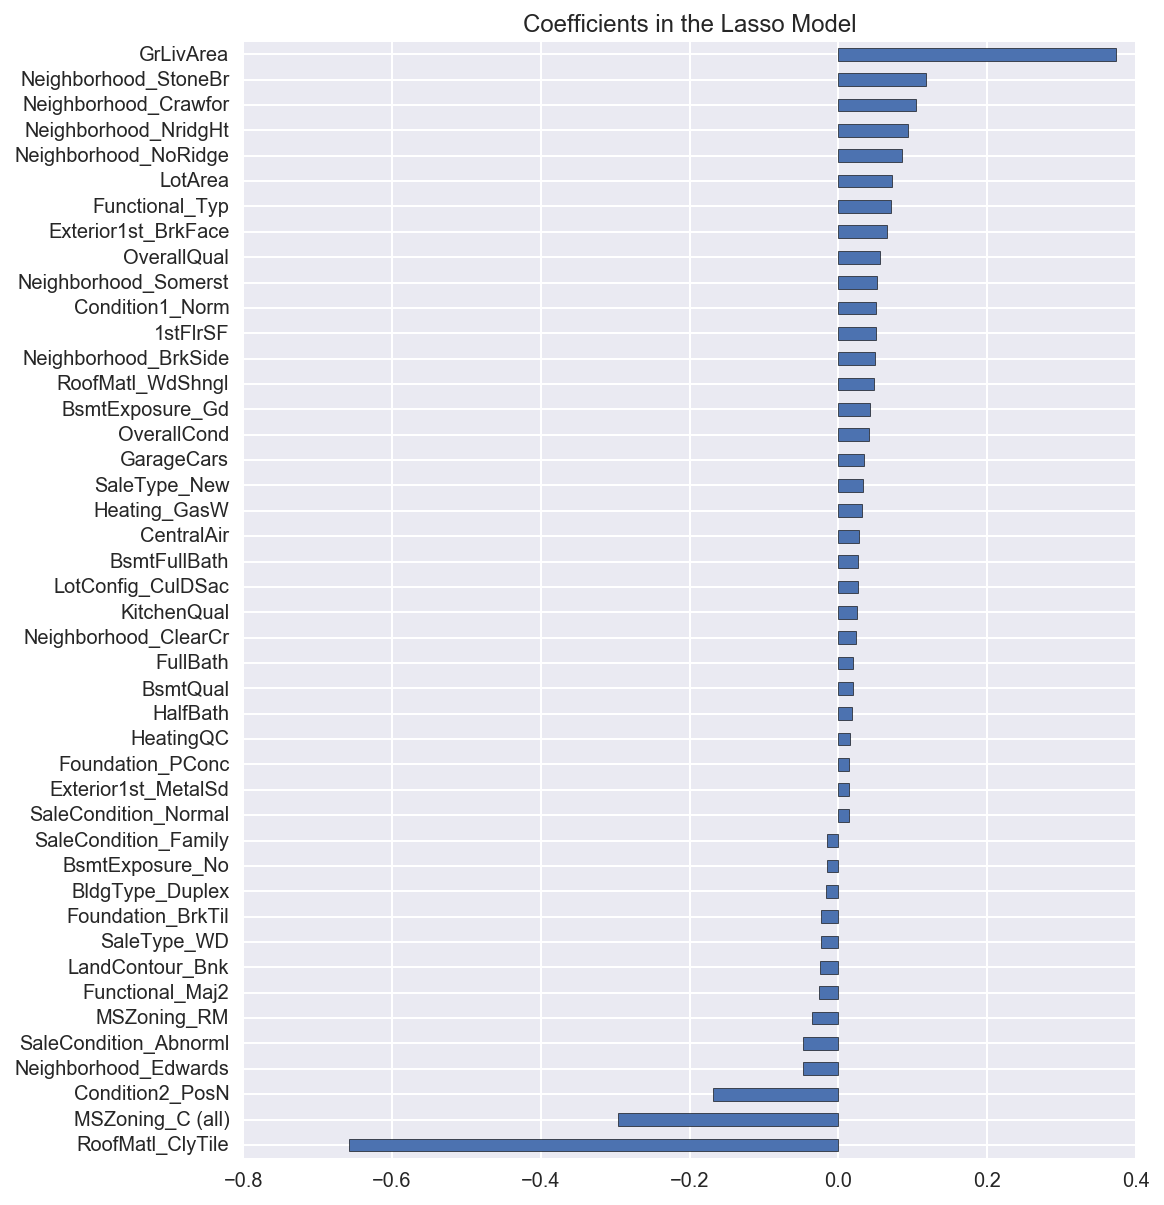

In [67]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

It appears that the data for clay tile roofing may be at issue, and needs to be investigated. Otherwise the commenciral zoning negative and ground floor living area fetures are the primary factors in predicting slaes price. 
Neighborhood is also a major factor.

However, after that the quality features (especially overall quality) began to come into play. 

I would like to see if overall quality is masking the other quality indicators in a separate test. That may be the key to having them play more into the prediction model.

I would also like to add some individual predictions or build a single property predictor to show how changes in single quality features (from Poor to Good or Excellent) affect the price. 

Additionally we should evalute the price per squarefoot as the target and not sales price to remove the area feature from play. It may also be worth while creating separate models for each neighborhood.